<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/GIT/Inference_with_GIT_for_image_video_captioning_and_image_video_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: using GIT for image/video captioning and image/video question answering (QA)

This notebook showcases how to use Microsoft's GIT model for captioning of images or videos, and question answering on images or videos.

It's advised to set "runtime" to GPU as it will make generation a lot faster.

### Quick intro: GIT

GIT (short for GenerativeImage2Text) is a standard Transformer decoder, conditioned on both CLIP image patch tokens and text tokens. The goal for the model is to simply predict the next text tokens, given the image tokens and the previous text tokens.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/git_architecture.jpg" alt="drawing" width="800"/>

The model itself is pre-trained on a large collection of (image, text) pairs. Note that the authors did not open-source the big GIT and GIT-2 models, but only smaller variants called GIT-base and GIT-large (as well as a lot of fine-tuned checkpoints). Nevertheless, these models are quite impressive and probably one the best open-source variants (for the respective tasks) at the moment!

## Set-up environment

First, let's install 🤗 Transformers. We install from source here since GIT was just added at the time of writing and not yet included in a new PyPi release.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 14.4 MB/s 
     |████████████████████████████████| 7.6 MB 65.2 MB/s 


## Load image

Next, we can load any image we'd like.

Downloading:   0%|          | 0.00/290k [00:00<?, ?B/s]

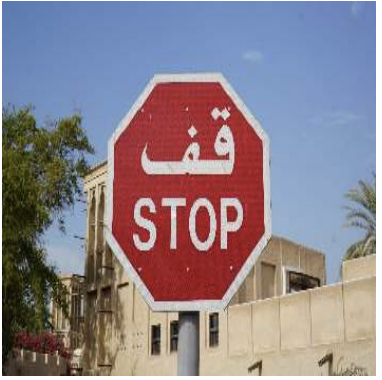

In [2]:
from huggingface_hub import hf_hub_download
from PIL import Image

filepath = hf_hub_download(repo_id="nielsr/textcaps-sample", filename="stop_sign.png", repo_type="dataset")
image = Image.open(filepath).convert("RGB")
image

## Prepare image for model

The image can be prepared for the model using `GitProcessor`. This processor includes both an image processor (for the image modality) and a tokenizer (for the text modality). Feeding it an image will make it use the image processor.

In [3]:
from transformers import AutoProcessor

# the Auto API automatically loads a GitProcessor for us
processor = AutoProcessor.from_pretrained("microsoft/git-base-textcaps")

pixel_values = processor(images=image, return_tensors="pt").pixel_values
pixel_values.shape

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/503 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

torch.Size([1, 3, 224, 224])

## Define model

Next, we load a GIT model from the [hub](https://huggingface.co/microsoft/git-base-textcaps). Here I'm loading a GIT based-sized model from the hub, fine-tuned on the [TextCaps](https://paperswithcode.com/dataset/textcaps) dataset (a large image captioning dataset).

In [4]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textcaps")

Downloading:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

## Generate caption

Generating a caption for the image is as simple as calling the [generate](https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/text_generation#transformers.GenerationMixin.generate) method, and passing the pixel values.

Note that we're using greedy decoding here by default, but there's a lot more, see [this blog](https://huggingface.co/blog/how-to-generate) for more info.

In [5]:
import torch

# run on the GPU if we have one
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
pixel_values = pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=20)
print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a stop sign with arabic writing on it']


## All in one go

Now that we've shown image captioning, we can show all tasks in short code snippets:

- image captioning
- visual question answering (VQA)
- video captioning
- video question answering (VQA)

### Image captioning

Let's load another image to perform captioning on.

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

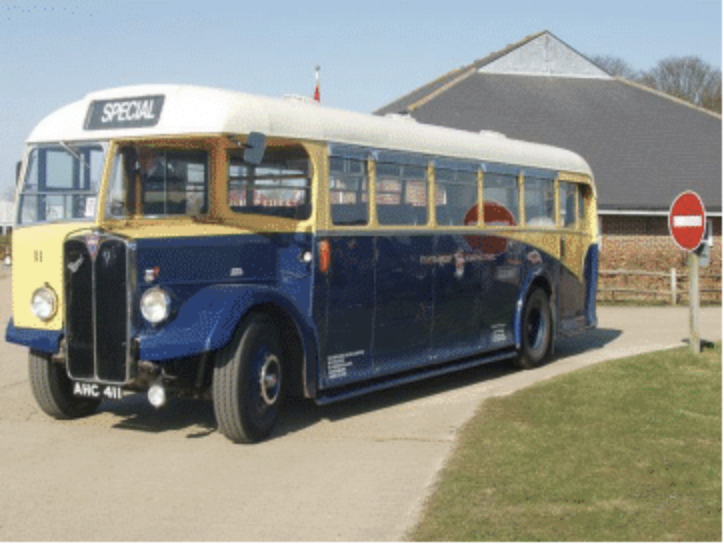

In [6]:
from huggingface_hub import hf_hub_download
from PIL import Image

def prepare_image():
  filepath = hf_hub_download(repo_id="nielsr/textvqa-sample", filename="bus.png", repo_type="dataset")
  image = Image.open(filepath).convert("RGB")
  
  return image

image = prepare_image()
image

Below we load a different GIT model from the 🤗 Hub, namely one that is fine-tuned on the COCO dataset.

In [7]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

model.to(device)
inputs = processor(images=prepare_image(), return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Downloading:   0%|          | 0.00/503 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

Generated caption: ['a bus that is parked in a driveway.']


### Visual question answering (VQA)

GIT is also fine-tuned on VQA datasets, like TextVQA. Let's ask a question to the model related to the bus image.

In [8]:
processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

pixel_values = processor(images=prepare_image(), return_tensors="pt").pixel_values

question = "what does the front of the bus say at the top?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)

print("Generated answer:", processor.batch_decode(generated_ids[:, input_ids.shape[1]:], skip_special_tokens=True))

Downloading:   0%|          | 0.00/503 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/709M [00:00<?, ?B/s]

Generated answer: ['special']


### Video captioning

The authors even fine-tune GIT on video captioning and video QA datasets.

To extend GIT to process video, the idea is simple: simply pass a few CLIP-embedded frames to the Transformer decoder as conditioning, together with a temporal embedding (see the figure at the top of this notebook for more info).

Let's install decord and load a GIT model fine-tuned on a video captioning dataset:

In [9]:
!pip install -q decord

     |████████████████████████████████| 13.6 MB 14.2 MB/s 


In [ ]:
# video captioning
processor = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vatex")

Let's load a video.

In [10]:
from ipywidgets import Video
from huggingface_hub import hf_hub_download

file_path = hf_hub_download(repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset")
Video.from_file(file_path, width=500)

Downloading:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0fI\xb7mdat\x00\x…

We need to sample a couple of frames from the video to feed them to GIT. The authors chose to use 6 frames per video. Hence we'll need to sample 6 frames from the video and feed those to the model.



In [17]:
num_frames = model.config.num_image_with_embedding
print(num_frames)

6


For decoding the video, we make use of the [decord](https://github.com/dmlc/decord) library. Sampling can be done using NumPy. We wrap this up in a function below:

In [18]:
import numpy as np
from decord import VideoReader, cpu

def sample_frames(file_path, num_frames):
    # set seed for reproducability
    np.random.seed(45)

    def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
        converted_len = int(clip_len * frame_sample_rate)
        end_idx = np.random.randint(converted_len, seg_len)
        start_idx = end_idx - converted_len
        indices = np.linspace(start_idx, end_idx, num=clip_len)
        indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
        return indices

    # video clip consists of 300 frames (10 seconds at 30 FPS)
    videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))

    # sample 6 frames
    videoreader.seek(0)
    indices = sample_frame_indices(clip_len=num_frames, frame_sample_rate=4, seg_len=len(videoreader))
    frames = videoreader.get_batch(indices).asnumpy()

    return list(frames)

frames = sample_frames(file_path, num_frames)

Of course performance of the model will heavily rely on which frames it sees. Let's see which frames we have sampled:

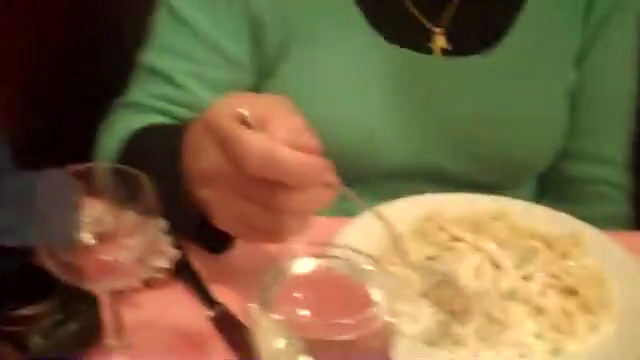

In [19]:
# visualize first sampled frame
Image.fromarray(frames[0])

Ok let's do a forward pass with those frames!

In [20]:
# move model to GPU
model.to(device)
# prepare frames for the model
inputs = processor(images=frames, return_tensors="pt").to(device)

generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)

print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

/usr/local/lib/python3.8/dist-packages/transformers/feature_extraction_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(value)


Generated caption: ['a woman is sitting at a table and she is talking about the food she is holding.']


### Video question answering

We can also use GIT to answer questions related to videos. The idea is exactly the same as video captioning, except that we also condition the model on some "question tokens", besides the frame tokens.

Let's load a GIT model, fine-tuned on a video QA dataset from the hub. In this case, we load GIT fine-tuned on the [MSRVTT-QA](https://paperswithcode.com/sota/visual-question-answering-on-msrvtt-qa-1) dataset.

In [21]:
# GIT fine-tuned on a video QA dataset
processor = AutoProcessor.from_pretrained("microsoft/git-base-msrvtt-qa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-msrvtt-qa")

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

In [22]:
# prepare video
inputs = processor(images=frames, return_tensors="pt").to(device)

# prepare question
question = "what is the woman eating?"

input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

print("Generating...")
model.to(device)
input_ids = input_ids.to(device)
generated_ids = model.generate(pixel_values=inputs.pixel_values, input_ids=input_ids, max_length=50)

print("Generated:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generating...
Generated: ['what is the woman eating? meal']
